## Modeling for predicting critical outcome at ED disposition

Flow:
1. task-specific filter: exclude ED death cases for train and test
2. variable selection
3. Modeling script
4. Performance output


### Load train and test

In [20]:
import pandas as pd
import numpy as np
import os
from helpers import PlotROCCurve
from sklearn.preprocessing import LabelEncoder
import time

#path = 'C:/Users/XFE/Documents/mimic4ed-benchmark/data_processed/'
path = '/home/jun/data/MIMIC/mimiciv/1.0/processed'

df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 0.95

In [25]:
pd.set_option('display.max_columns', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcomplaint,chiefcom_chest_pain,...,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS,score_SERP2d,score_SERP7d,score_SERP30d
0,215414,18566742,27103162.0,38538786,2135-07-16 16:08:00,2135-07-17 01:49:00,58,F,2132,NaN,2135-07-17 00:20:00,2135-07-18 18:20:00,NaN,HISPANIC/LATINO,2135-07-16 16:08:00,2135-07-17 01:49:00,Other,2135,61,False,False,False,0 days 09:41:00,NaN,NaN,False,True,False,0,0,0,2136-07-30 17:08:00,379 days 15:19:00,False,0,0,0,0,0,0,37.166667,93.0,16.0,100.0,160.0,66.0,4.167576,3.0,LOWER ABD PAIN,False,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.760621,78.220568,17.260731,98.141378,127.427849,73.556876,2.127651,5.0,2.0,97.333333,4,3,1,1,1,16,21,16
1,205452,16853729,NaN,30043998,2178-01-25 05:09:00,2178-01-25 07:05:00,91,F,2169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2178,100,False,False,False,0 days 01:56:00,NaN,NaN,False,False,False,0,1,7,2178-03-11 09:43:00,45 days 02:38:00,False,0,0,5,0,0,0,36.666667,76.0,20.0,95.0,165.0,95.0,4.167576,2.0,Dyspnea,False,...,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.777778,75.000000,18.000000,97.000000,133.000000,80.000000,2.127651,2.0,3.0,118.333333,9,8,1,0,1,28,33,29
2,200705,16026698,NaN,39475313,2128-10-19 20:01:00,2128-10-19 20:16:00,23,M,2128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2128,23,False,False,False,0 days 00:15:00,NaN,NaN,False,False,False,0,0,1,2129-01-05 21:12:00,78 days 00:56:00,False,0,0,0,0,0,0,37.222222,125.0,22.0,99.0,156.0,96.0,7.000000,2.0,"ILI, Cough",False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.833333,95.000000,18.000000,100.000000,143.000000,82.000000,7.000000,1.0,1.0,116.000000,12,4,4,4,4,18,20,17
3,87038,15398519,25237915.0,35495155,2147-06-15 09:50:00,2147-06-15 15:55:00,57,M,2136,NaN,2147-06-15 14:00:00,2147-06-16 16:45:00,NaN,BLACK/AFRICAN AMERICAN,2147-06-15 09:50:00,2147-06-15 15:55:00,Medicare,2147,68,False,False,False,0 days 06:05:00,NaN,NaN,False,True,False,0,2,5,2147-07-01 10:46:00,15 days 18:51:00,False,0,2,5,0,0,1,37.166667,110.0,22.0,92.0,122.0,89.0,7.000000,2.0,"Chest pain, Dyspnea",True,...,1,0,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,36.777778,106.000000,20.000000,92.000000,96.000000,75.000000,0.000000,7.0,10.0,100.000000,16,7,5,3,3,36,36,31
4,373626,16787687,23674090.0,31087259,2181-03-20 10:38:00,2181-03-21 12:55:00,87,F,2176,NaN,2181-03-20 22:01:00,2181-03-21 12:55:00,NaN,BLACK/AFRICAN AMERICAN,2181-03-20 10:38:00,2181-03-21 12:55:00,Medicare,2181,92,False,False,False,1 days 02:17:00,NaN,NaN,False,True,False,0,0,2,2181-04-06 09:43:00,15 days 20:48:00,False,0,0,2,0,0,0,37.111111,90.0,14.0,99.0,125.0,68.0,3.000000,3.0,Lower back pain,False,...,0,1,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,36.666667,74.000000,18.000000,98.000000,100.000000,59.000000,0.000000,6.0,13.0,87.000000,9,6,0,0,0,32,36,31


In [22]:
#revise time range + function name

### 1. task-specific filter: exclude ED death cases for train and test

In [23]:
df_train = df_train[df_train['ed_death'] == False]
df_test = df_test[df_test['ed_death'] == False]

### 2. Variable Selection

In [24]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

In [25]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [26]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [27]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [28]:
print('class ratio')
print('positive : negative =', y_train.sum()/(~y_train).sum(), ': 1')

class ratio
positive : negative = 0.07053365376014503 : 1


### 3.  Modeling script

In [29]:
# Containers for all results
result_list = []

Logistic Regression:


/home/jun/virtualenvs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.964929819107056 seconds
AUC: 0.844728597513773
AP(AUPRC): 0.31846220162093547
Sensitivity: 0.7859311740890689
Specificity: 0.7292919171676686
Score thresold: 0.058781732026283055


No handles with labels found to put in legend.


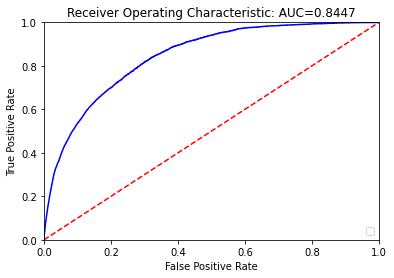

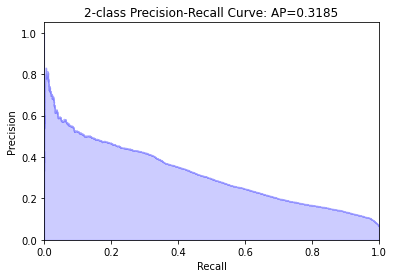

In [30]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



MLP:
Training time: 711.0269622802734 seconds
AUC: 0.886624791498684
AP(AUPRC): 0.40904758355519616
Sensitivity: 0.8152834008097166
Specificity: 0.8015316346979674
Score thresold: 0.06821413653934191


No handles with labels found to put in legend.


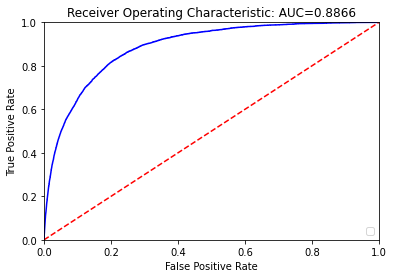

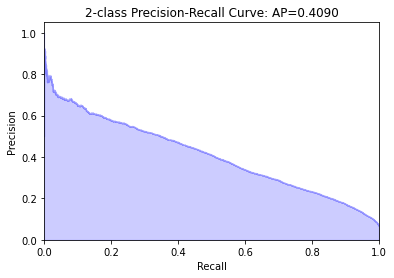

In [31]:
print("MLP:")
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
start = time.time()
mlp.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = mlp.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)


RandomForest:
Training time: 58.979466676712036 seconds
AUC: 0.8856493008992087
AP(AUPRC): 0.41983609115225384
Sensitivity: 0.8073549257759784
Specificity: 0.8086291630880809
Score thresold: 0.08152446230901375


No handles with labels found to put in legend.


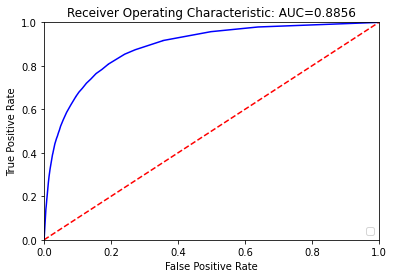

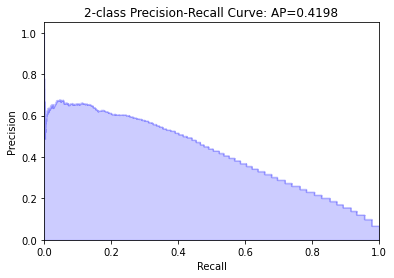

[0.1016132  0.01436934 0.00640979 0.01020071 0.01910898 0.0062614
 0.00982402 0.01670882 0.00328795 0.00637774 0.01164235 0.0759727
 0.09254575 0.05510171 0.06622985 0.09583725 0.08177721 0.04537456
 0.08487792 0.00564516 0.00607638 0.00368913 0.0014948  0.00215964
 0.00226419 0.00276289 0.00450693 0.00323777 0.00284212 0.00506386
 0.00555667 0.0049009  0.00497213 0.00282021 0.00725396 0.00269819
 0.00266921 0.0046514  0.00719626 0.00471767 0.00240214 0.00489452
 0.00536206 0.00282567 0.00378696 0.00105264 0.00692726 0.0046459
 0.00436143 0.00473219 0.00872772 0.00590441 0.00547505 0.00165402
 0.00528146 0.00549544 0.00450648 0.00690601 0.00218177 0.00434304
 0.00474502 0.00371032 0.00252798 0.00684978]


In [32]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 68.71127223968506 seconds
AUC: 0.8936031966896327
AP(AUPRC): 0.43713527537888847
Sensitivity: 0.8242240215924427
Specificity: 0.8042275026242962
Score thresold: 0.07080459175735267


No handles with labels found to put in legend.


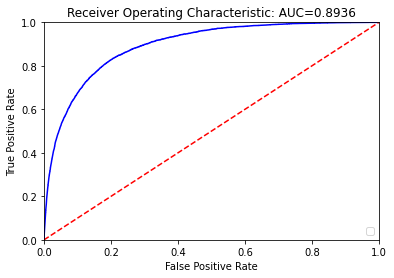

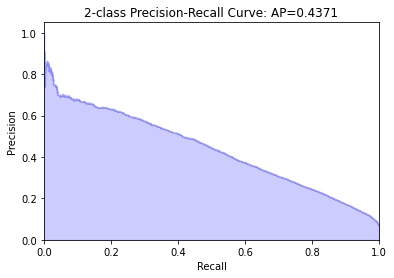

In [33]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [34]:
# Temporal skip
'''
print("Support Vector Machine:")
from sklearn.svm import SVC
svc=SVC()
start = time.time()
svc.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = svc.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["SVM"]
results.extend(result)
results.append(runtime)
result_list.append(results)
'''

'\nprint("Support Vector Machine:")\nfrom sklearn.svm import SVC\nsvc=SVC()\nstart = time.time()\nsvc.fit(X_train,y_train)\nruntime = time.time()-start\nprint(\'Training time:\', runtime, \'seconds\')\nprobs = svc.predict_proba(X_test)\nresult = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)\n\nresults = ["SVM"]\nresults.extend(result)\nresults.append(runtime)\nresult_list.append(results)\n'

In [35]:
def get_score_performance(s):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


esi
AUC: 0.789784020478139
AP(AUPRC): 0.1944936375006208
Sensitivity: 0.8959176788124157
Specificity: 0.6333142475427045
Score thresold: -2.6248987751080204


No handles with labels found to put in legend.


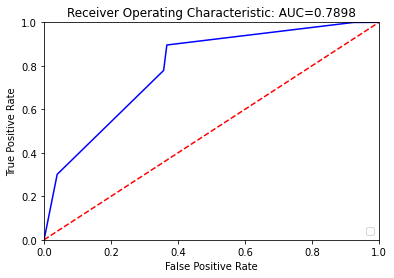

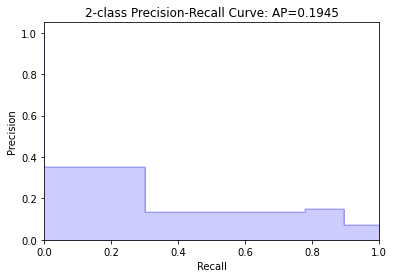

In [36]:
df_test["ESI"] = -df_test["triage_acuity"]
get_score_performance("ESI")

score_NEWS
AUC: 0.6002591746052351
AP(AUPRC): 0.1525796637565012
Sensitivity: 0.4144736842105263
Specificity: 0.7993129115373605
Score thresold: 2


No handles with labels found to put in legend.


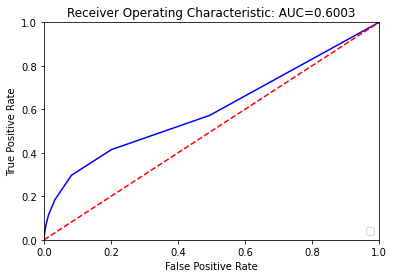

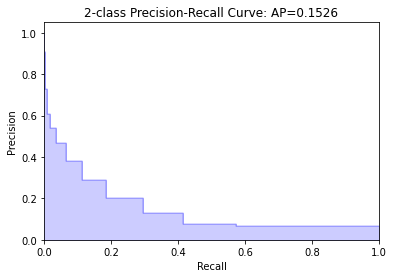

In [37]:
get_score_performance("score_NEWS")

score_NEWS2
AUC: 0.587080282037631
AP(AUPRC): 0.13968412809478523
Sensitivity: 0.37449392712550605
Specificity: 0.8263789483729364
Score thresold: 2


No handles with labels found to put in legend.


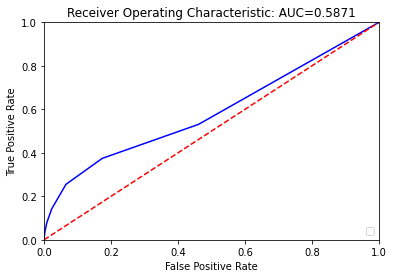

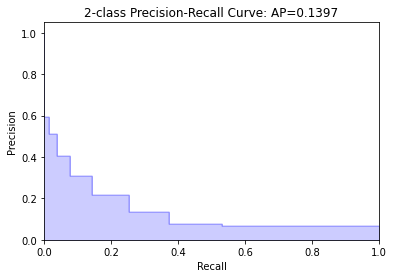

In [38]:
get_score_performance("score_NEWS2")

score_REMS
AUC: 0.6638998005167845
AP(AUPRC): 0.11202249052255793
Sensitivity: 0.645748987854251
Specificity: 0.6163517511212901
Score thresold: 5


No handles with labels found to put in legend.


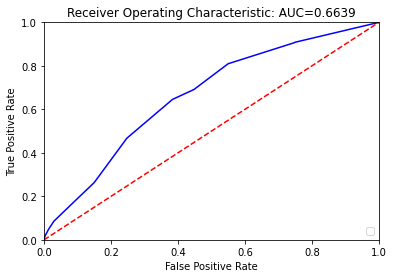

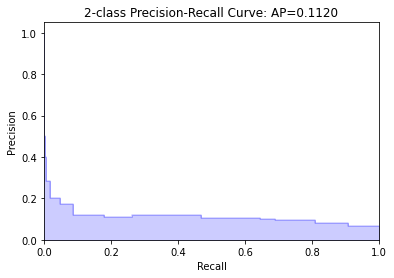

In [39]:
get_score_performance("score_REMS")

score_MEWS
AUC: 0.6056137210559542
AP(AUPRC): 0.11437508107058239
Sensitivity: 0.40468960863697706
Specificity: 0.7761356045424181
Score thresold: 2


No handles with labels found to put in legend.


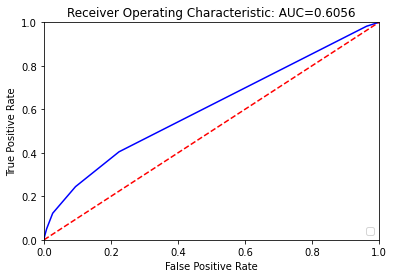

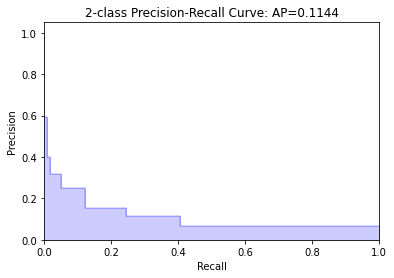

In [40]:
get_score_performance("score_MEWS")

score_CART
AUC: 0.6923679410907155
AP(AUPRC): 0.15759081132763783
Sensitivity: 0.5588731443994602
Specificity: 0.7325603588128637
Score thresold: 6


No handles with labels found to put in legend.


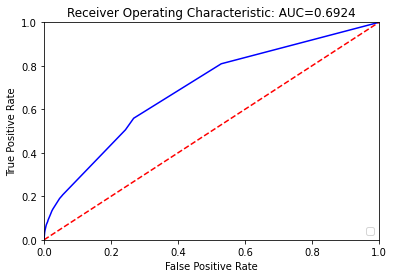

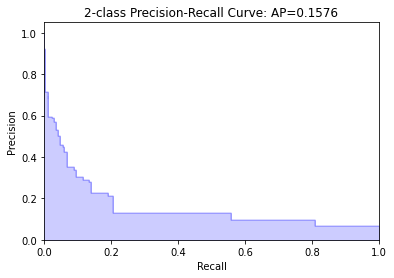

In [41]:
get_score_performance("score_CART")

### 4. Performance output

In [42]:
#result_df = pd.read_csv(os.path.join(path, 'result_critical_triage.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'roc_auc', 'average_precision', 'sensitivity', 'specificity', 'threshold', 'average_precision', 'lower_auroc', 'upper_auroc', 'lower_ap', 'upper_ap', 'lower_sensitivity', 'upper_sensitivity', 'lower_specificity', 'upper_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_triage.csv'), index=False)
result_df.head()

,Model,roc_auc,average_precision,sensitivity,specificity,threshold,average_precision,lower_auroc,upper_auroc,lower_ap,upper_ap,lower_sensitivity,upper_sensitivity,lower_specificity,upper_specificity,runtime
0,LR,0.844729,0.318462,0.785931,0.729292,0.058782,0.318462,0.844691,0.844985,0.318665,0.319452,0.770010,0.772244,0.741538,0.742889,5.964930
1,MLP,0.886625,0.409048,0.815283,0.801532,0.068214,0.409048,0.886518,0.886774,0.409213,0.410045,0.819026,0.819750,0.799187,0.799940,711.026962
2,RF,0.885649,0.419836,0.807355,0.808629,0.081524,0.419836,0.885525,0.885819,0.419740,0.420734,0.807565,0.808185,0.808494,0.808670,58.979467
3,GB,0.893603,0.437135,0.824224,0.804228,0.070805,0.437135,0.893609,0.893842,0.436852,0.437833,0.821290,0.822329,0.806366,0.807850,68.711272
4,esi,0.789784,0.194494,0.895918,0.633314,-2.624899,0.194494,0.789667,0.790042,0.194101,0.194601,0.895857,0.896285,0.633064,0.633264,0.000000


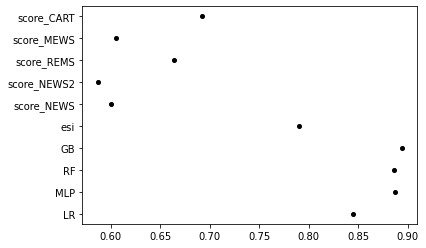

In [43]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df)

In [44]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,age,0.101613
15,triage_sbp,0.095837
12,triage_heartrate,0.092546
18,triage_acuity,0.084878
16,triage_dbp,0.081777
...,...,...
58,eci_BloodLoss,0.002182
23,chiefcom_back_pain,0.002160
53,eci_Lymphoma,0.001654
22,chiefcom_shortness_of_breath,0.001495
